
### Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import json
import matplotlib.pyplot as plt
import os

### Let's see what's in the folder Spotify sends

In [2]:
spotify_data = "./spotify_data/"

files = os.listdir(spotify_data)

files

['Follow.json',
 '.DS_Store',
 'StreamingHistory2.json',
 'Userdata.json',
 'StreamingHistory3.json',
 'StreamingHistory0.json',
 'YourLibrary.json',
 'StreamingHistory1.json',
 'madpeople.tsv']

### JSON reader function

In [3]:
def load_json(json_filename):
    with open(json_filename, encoding="utf8") as f:
        dict_from_json = json.loads(f.read())
    return dict_from_json

def json_to_df(json_filename):
    json_file = load_json(json_filename)
    return pd.DataFrame(json_file)

### Check that it's my stuff

Also define a function to read json files as Python dictionaries

In [4]:
userdata = load_json(spotify_data + "Userdata.json")

userdata

{'username': 'dgarhdez',
 'email': 'dgarhdez@gmail.com',
 'country': 'ES',
 'createdFromFacebook': False,
 'facebookUid': None,
 'birthdate': '1987-12-17',
 'gender': 'male',
 'postalCode': '28729',
 'mobileNumber': None,
 'mobileOperator': None,
 'mobileBrand': None,
 'creationTime': '2009-05-26'}

### Load streaming history as a single dataframe

In [5]:
# create a list of my streaming history files
streaming_history = [file for file in files if "StreamingHistory" in file]

streaming_history

['StreamingHistory2.json',
 'StreamingHistory3.json',
 'StreamingHistory0.json',
 'StreamingHistory1.json']

In [6]:
# load each file as dataframe and then concat
list_df = []

#list_df=[pd.DataFrame(load_json(spotify_data + item)) for item in streaming_history]

for item in streaming_history:
    item_dict = load_json(spotify_data + item)
    item_df = pd.DataFrame(item_dict)
    list_df.append(item_df)

df_history = (
    pd
    .concat(list_df)  
    .sort_values(by="endTime")
    .reset_index(drop=True)
)

df_history

,endTime,artistName,trackName,msPlayed
0,2018-12-29 13:29,Jeff Buckley,Everybody Here Wants You,195299
1,2018-12-29 13:33,Future Islands,Time On Her Side,218506
2,2018-12-29 13:35,The Whitest Boy Alive,Burning,144044
3,2018-12-29 13:36,The Whitest Boy Alive,Burning,47144
4,2018-12-29 13:41,Cut Copy,Take Me Over,248289
...,...,...,...,...
30161,2019-12-29 12:47,El Palacio de Linares,Ciervo y Erizo,149266
30162,2019-12-29 12:48,Los Chikos del Maiz,Grupo Salvaje,19772
30163,2019-12-29 13:00,Los Chikos del Maiz,Grupo Salvaje,169087
30164,2019-12-29 13:03,John Grant,GMF,181394


In [7]:
df_history.dtypes

endTime       object
artistName    object
trackName     object
msPlayed       int64
dtype: object

In [8]:
df_history.describe()

,msPlayed
count,3.016600e+04
mean,1.480600e+05
std,1.085951e+05
min,0.000000e+00
25%,5.009600e+04
50%,1.528260e+05
75%,2.198798e+05
max,1.812570e+06


In [9]:
df_history.isnull().mean()

endTime       0.0
artistName    0.0
trackName     0.0
msPlayed      0.0
dtype: float64

### Work on endTime column and create more time-related variables

In [10]:
# convert msPlayed to seconds
df_history["sec_played"] = np.where(
    df_history["msPlayed"]>=1000,
    np.round(df_history["msPlayed"] / 1000, 0).astype(int),
    1
)

# convert seconds to timedelta
df_history["sec_played_td"] = [pd.Timedelta(seconds=sec) for sec in df_history["sec_played"]]

# convert endTime to datetime object
df_history["endTime"] = pd.to_datetime(df_history["endTime"])

# substract sec_played to endTime to calculate start_time
df_history["start_time"] = df_history["endTime"] - df_history["sec_played_td"]

# time-related features
df_history["year"] = df_history["start_time"].dt.year
df_history["month"] = df_history["start_time"].dt.month
df_history["year_month"] = df_history["start_time"].dt.strftime('%Y_%m')
df_history["day"] = df_history["start_time"].dt.day
df_history["hour"] = df_history["start_time"].dt.hour
df_history["weekday"] = df_history["start_time"].dt.weekday
df_history["weekend"] = df_history["weekday"].map(lambda x: 1*(x>4))

df_history.sample(5)

,endTime,artistName,trackName,msPlayed,sec_played,sec_played_td,start_time,year,month,year_month,day,hour,weekday,weekend
243,2018-12-31 18:37:00,Amy Winehouse,What Is It About Men,209560,210,00:03:30,2018-12-31 18:33:30,2018,12,2018_12,31,18,0,0
18108,2019-07-15 15:04:00,C. Tangana,Para Repartir,180868,181,00:03:01,2019-07-15 15:00:59,2019,7,2019_07,15,15,0,0
4511,2019-02-13 12:33:00,Ellos,Campeón,75121,75,00:01:15,2019-02-13 12:31:45,2019,2,2019_02,13,12,2,0
21905,2019-08-29 14:52:00,Tank and The Bangas,Hot Air Balloons,343320,343,00:05:43,2019-08-29 14:46:17,2019,8,2019_08,29,14,3,0
3612,2019-02-06 09:16:00,La Costa Brava,El Hombre Que Perdió los Papeles,1045,1,00:00:01,2019-02-06 09:15:59,2019,2,2019_02,6,9,2,0


### Most played band, most played song

In [14]:
# value_counts returns a ordered series including the count for each category in a categorical feature
df_history["artistName"].value_counts()

Jens Lekman            1185
Los Ganglios            882
Carolina Durante        780
Rusos Blancos           776
Los Chikos del Maiz     655
                       ... 
Giorgio Poi               1
Anonymous                 1
GentleBeatz               1
Étienne de Crécy          1
John Powell               1
Name: artistName, Length: 1927, dtype: int64

In [15]:
df_history["trackName"].value_counts()

No Sabes Mentir                       123
Libreros                              114
Llorando en la Limo (feat. Alizzz)    112
Llorando En La Limo                   105
Cariño                                 92
                                     ... 
Salvaje                                 1
Ave Rapaz                               1
Time To Go                              1
Y Además Bastante Fea                   1
Darts Of Pleasure                       1
Name: trackName, Length: 7664, dtype: int64

### When do I usually listen to music? 

In [16]:
songs_per_hour = (
    df_history
    .groupby("hour")
    .count()
    [["endTime"]]
    .rename(columns={"endTime": "total_songs"})
)

songs_per_hour.head()

,total_songs
hour,
0,155
1,124
2,105
3,113
4,128


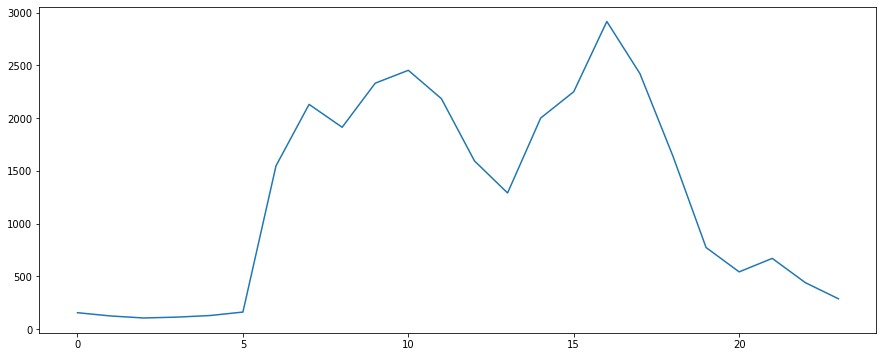

In [17]:
plt.figure(figsize=(15,6))
plt.plot(songs_per_hour.index, songs_per_hour["total_songs"])
plt.show()

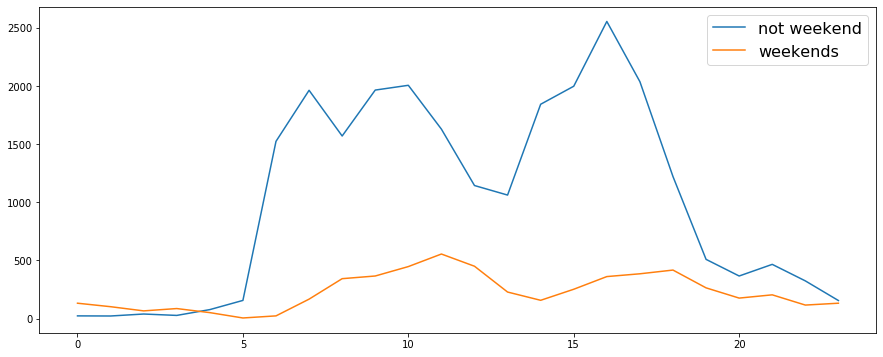

In [203]:
# weekdays vs weekends
songs_not_weekend = (
    df_history
    .query("weekend == 0")
    .groupby("hour")
    .count()
    [["endTime"]]
    .rename(columns={"endTime": "total_songs"})
)

songs_weekends = (
    df_history
    .query("weekend == 1")
    .groupby("hour")
    .count()
    [["endTime"]]
    .rename(columns={"endTime": "total_songs"})
)

plt.figure(figsize=(15,6))
plt.plot(songs_not_weekend.index, songs_not_weekend["total_songs"], label="not weekend")
plt.plot(songs_weekends.index, songs_weekends["total_songs"], label="weekends")
plt.legend(fontsize=16)
plt.show()

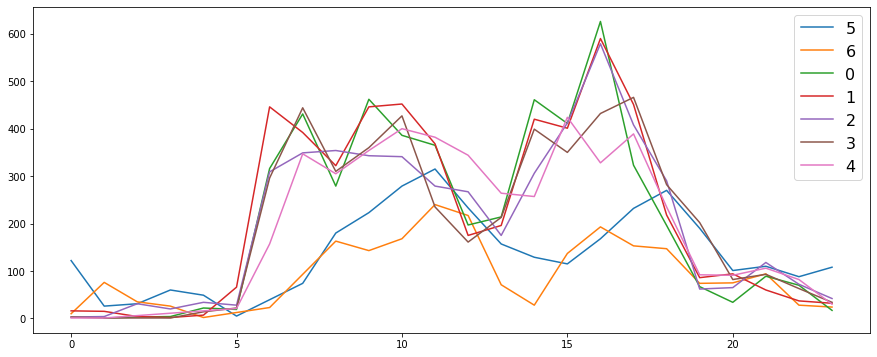

In [18]:
# per hour and per day of the week

plt.figure(figsize=(15,6))
for wkday in df_history["weekday"].unique():
    songs_weekday = (
        df_history
        .query("weekday == @wkday")
        .groupby("hour")
        .count()
        [["endTime"]]
        .rename(columns={"endTime": "total_songs"})  
    )
    
    plt.plot(songs_weekday.index, songs_weekday["total_songs"], label=wkday)

plt.legend(fontsize=16)
plt.show()

In [19]:
# convert hour to category: night, morning, afternoon, evening

df_history["day_period"] = pd.cut(
    df_history["hour"], 
    bins=[0, 6, 14, 18, 24],
    labels=["night", "morning", "afternoon", "evening"]
)

df_history.sample(5)

,endTime,artistName,trackName,msPlayed,sec_played,sec_played_td,start_time,year,month,year_month,day,hour,weekday,weekend,day_period
26606,2019-11-06 20:07:00,Wolfgang Amadeus Mozart,"Clarinet Concerto in A Major, K. 622: I. Allegro",8359,8,00:00:08,2019-11-06 20:06:52,2019,11,2019_11,6,20,2,0,evening
24031,2019-10-05 14:08:00,Phillipa Soo,Helpless,82004,82,00:01:22,2019-10-05 14:06:38,2019,10,2019_10,5,14,5,1,morning
23572,2019-09-28 16:29:00,Father John Misty,Pure Comedy,172871,173,00:02:53,2019-09-28 16:26:07,2019,9,2019_09,28,16,5,1,afternoon
15465,2019-06-20 16:30:00,Pulp,Love Is Blind (Live),3552,4,00:00:04,2019-06-20 16:29:56,2019,6,2019_06,20,16,3,0,afternoon
27542,2019-11-24 17:45:00,Tribade,Mujeres,226250,226,00:03:46,2019-11-24 17:41:14,2019,11,2019_11,24,17,6,1,afternoon


In [20]:
df_history.groupby("day_period").count()["endTime"]

day_period
night         2178
morning      15895
afternoon     9226
evening       2712
Name: endTime, dtype: int64

### Evolution of played songs during the year

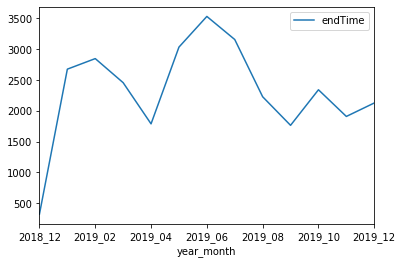

In [21]:
df_history.groupby("year_month").count()[["endTime"]].plot()

### Acummulated time listening to music

In [22]:
df_history["accum_play_time"] = df_history["sec_played"].cumsum()

df_history.head()

,endTime,artistName,trackName,msPlayed,sec_played,sec_played_td,start_time,year,month,year_month,day,hour,weekday,weekend,day_period,accum_play_time
0,2018-12-29 13:29:00,Jeff Buckley,Everybody Here Wants You,195299,195,00:03:15,2018-12-29 13:25:45,2018,12,2018_12,29,13,5,1,morning,195
1,2018-12-29 13:33:00,Future Islands,Time On Her Side,218506,219,00:03:39,2018-12-29 13:29:21,2018,12,2018_12,29,13,5,1,morning,414
2,2018-12-29 13:35:00,The Whitest Boy Alive,Burning,144044,144,00:02:24,2018-12-29 13:32:36,2018,12,2018_12,29,13,5,1,morning,558
3,2018-12-29 13:36:00,The Whitest Boy Alive,Burning,47144,47,00:00:47,2018-12-29 13:35:13,2018,12,2018_12,29,13,5,1,morning,605
4,2018-12-29 13:41:00,Cut Copy,Take Me Over,248289,248,00:04:08,2018-12-29 13:36:52,2018,12,2018_12,29,13,5,1,morning,853


In [243]:
total_time = df_history.tail(1)["accum_play_time"].values[0]

total_hours = total_time // 3600
total_minutes = (total_time - total_hours * 3600) // 60

print(f"total time: {total_hours} hours and {total_minutes} minutes")

total time: 1240 hours and 56 minutes


### Distribution of my listening time

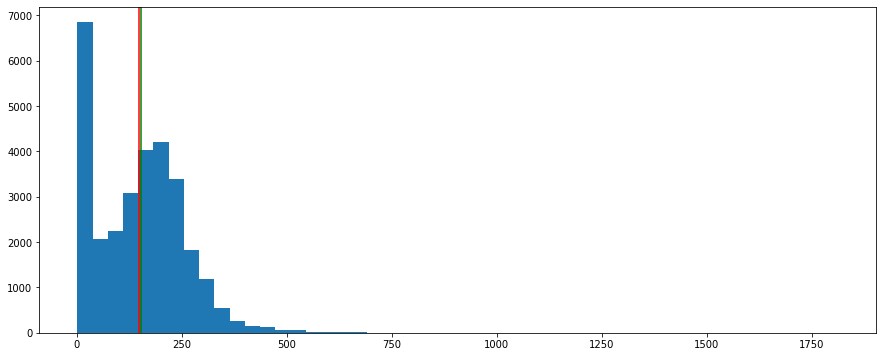

In [23]:
mean_listening_time = df_history["sec_played"].mean()
median_listening_time = df_history["sec_played"].median()

plt.figure(figsize=(15, 6))
plt.hist(df_history["sec_played"], bins=50)
plt.axvline(mean_listening_time, c="red")
plt.axvline(median_listening_time, c="green")
plt.show()

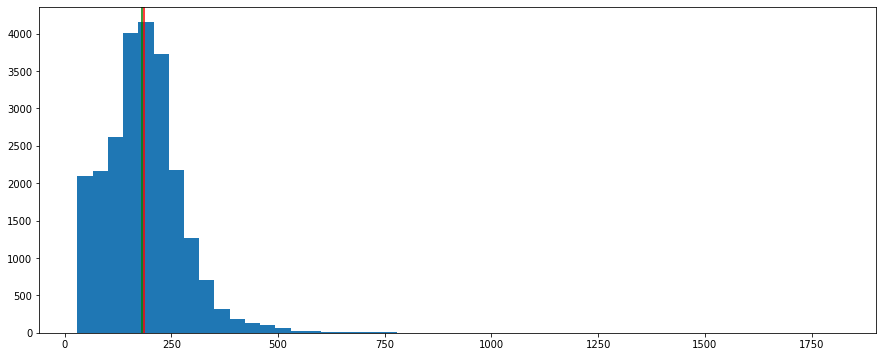

In [24]:
# let's filter those songs that I listen for less than 30 s
listened_m30s = df_history.query("sec_played >= 30")
mean_listening_time_m30 = listened_m30s["sec_played"].mean()
median_listening_time_m30 = listened_m30s["sec_played"].median()

plt.figure(figsize=(15, 6))
plt.hist(listened_m30s["sec_played"], bins=50)
plt.axvline(mean_listening_time_m30, c="red")
plt.axvline(median_listening_time_m30, c="green")
plt.show()